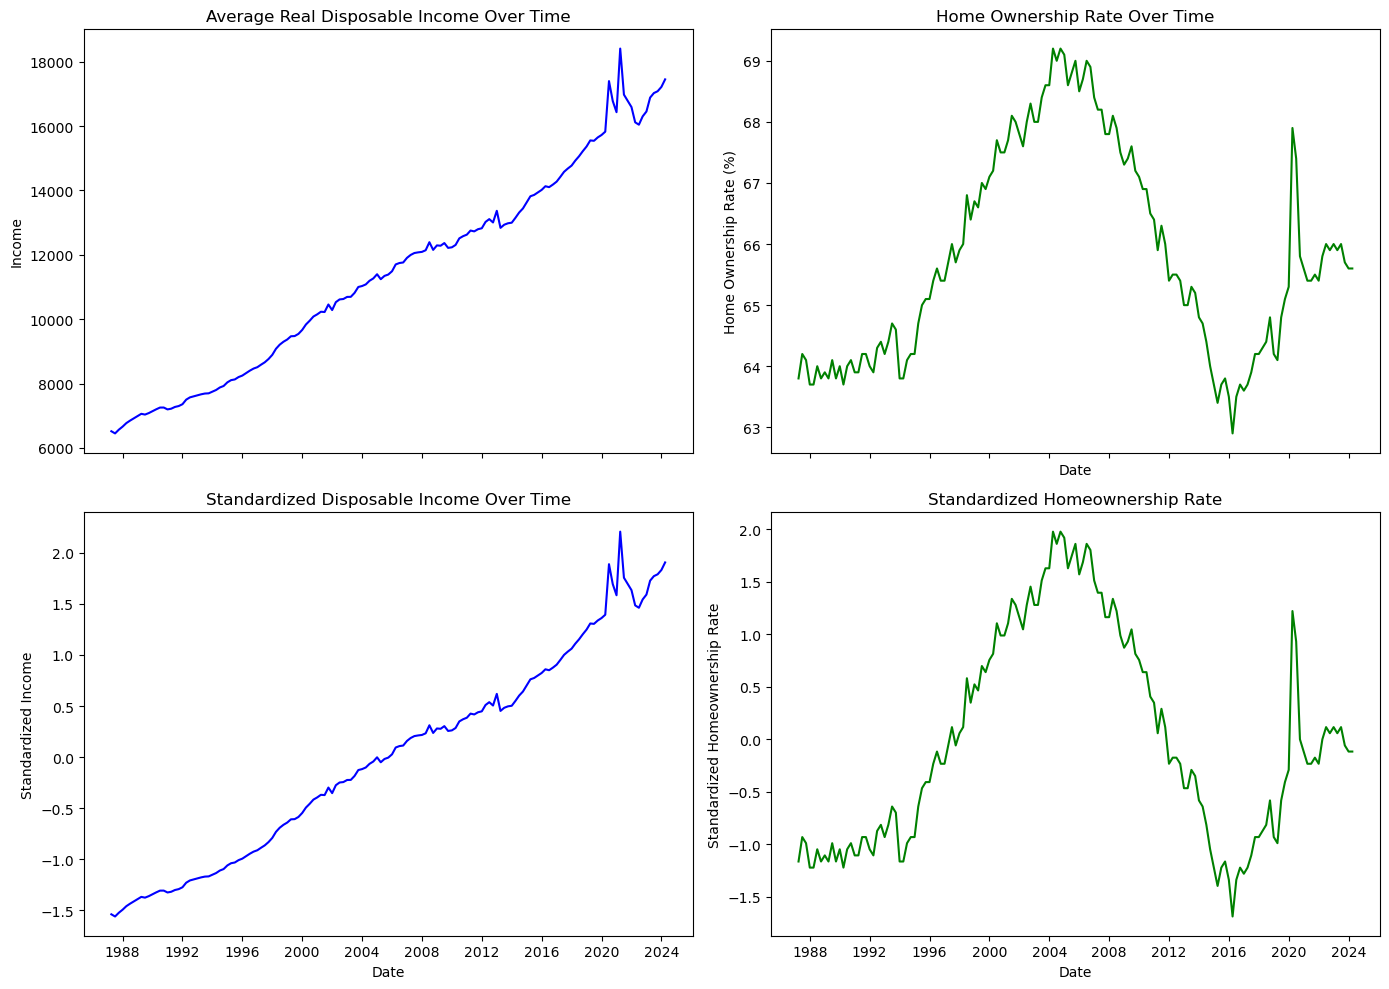

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
income_df = pd.read_csv('DSPIC96.csv', parse_dates=['DATE'])
home_ownership_df = pd.read_csv('RHORUSQ156N.csv', parse_dates=['DATE'])
home_price_index_df = pd.read_csv("CSUSHPINSA.csv", parse_dates=['DATE'])
consumer_debt_df = pd.read_csv("CDSP.csv", parse_dates=['DATE'])

# Resample income to quarterly if needed
income_df.set_index('DATE', inplace=True)
home_ownership_df.set_index('DATE', inplace=True)
home_price_index_df.set_index('DATE', inplace=True)
consumer_debt_df.set_index('DATE', inplace=True)

# Resample monthly data to quarterly using mean or forward fill methods
income_quarterly = income_df.resample('Q').mean()  # or use .ffill() for forward filling if preferable
home_price_index_quarterly = home_price_index_df.resample('Q').mean()

# Merge the datasets on the 'Date' index
income_quarterly.index = income_quarterly.index + pd.DateOffset(days=1)
home_price_index_quarterly.index = home_price_index_quarterly.index + pd.DateOffset(days=1)
merged_data = pd.merge(income_quarterly, home_ownership_df, on='DATE', how='inner')
merged_data = pd.merge(merged_data, home_price_index_quarterly, on='DATE', how='inner')
merged_data = pd.merge(merged_data, consumer_debt_df, on='DATE', how='inner')


merged_data['Income_std'] = (merged_data['DSPIC96'] - merged_data['DSPIC96'].mean()) / merged_data['DSPIC96'].std()
merged_data['HomeOwnershipRate_std'] = (merged_data['RHORUSQ156N'] - merged_data['RHORUSQ156N'].mean()) / merged_data['RHORUSQ156N'].std()
merged_data['HPIndex_std'] = (merged_data['CSUSHPINSA'] - merged_data['CSUSHPINSA'].mean()) / merged_data['CSUSHPINSA'].std()
merged_data['ConsumerDebtIndex_std'] = (merged_data['CDSP'] - merged_data['CDSP'].mean()) / merged_data['CDSP'].std()

# Plotting in separate subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot Disposable Income
axs[0,0].plot(merged_data['DSPIC96'], color='blue')
axs[0,0].set_title("Average Real Disposable Income Over Time")
axs[0,0].set_ylabel("Income")

# Plot Home Ownership Rate
axs[0,1].plot(merged_data['RHORUSQ156N'], color='green')
axs[0,1].set_title("Home Ownership Rate Over Time")
axs[0,1].set_ylabel("Home Ownership Rate (%)")
axs[0,1].set_xlabel("Date")

axs[1,0].plot(merged_data['Income_std'], label="Standardized Disposable Income", color='blue')
axs[1,0].set_title("Standardized Disposable Income Over Time")
axs[1,0].set_ylabel("Standardized Income")
axs[1,0].set_xlabel("Date")

axs[1,1].plot(merged_data['HomeOwnershipRate_std'], label="Standardized Home Ownership Rate", color='green')
axs[1,1].set_title("Standardized Homeownership Rate")
axs[1,1].set_ylabel("Standardized Homeownership Rate")
axs[1,1].set_xlabel("Date")


plt.tight_layout()
plt.show()


In [65]:
merged_data

,DSPIC96,RHORUSQ156N,CSUSHPINSA,CDSP,Income_std,HomeOwnershipRate_std,HPIndex_std,ConsumerDebtIndex_std
DATE,,,,,,,,
1987-04-01,6516.566667,63.8,64.111333,6.273851,-1.538210,-1.163624,-1.250092,0.698393
1987-07-01,6448.966667,64.2,65.577667,6.179090,-1.559502,-0.930977,-1.227209,0.555418
1987-10-01,6565.033333,64.1,67.225667,6.096414,-1.522945,-0.989139,-1.201492,0.430677
1988-01-01,6659.733333,63.7,68.111333,6.031035,-1.493118,-1.221786,-1.187670,0.332034
1988-04-01,6769.333333,63.7,68.939000,5.974719,-1.458598,-1.221786,-1.174754,0.247065
...,...,...,...,...,...,...,...,...
2023-04-01,16885.200000,65.9,294.665333,5.158004,1.727520,0.057771,2.347805,-0.985190
2023-07-01,17025.166667,66.0,305.245667,5.276051,1.771604,0.115933,2.512916,-0.807081
2023-10-01,17082.833333,65.7,311.611333,5.649808,1.789767,-0.058552,2.612255,-0.243159


income_df

ADF Statistic: -4.436840677298332
p-value: 0.0002553045637290202
Residuals are stationary (reject null hypothesis).


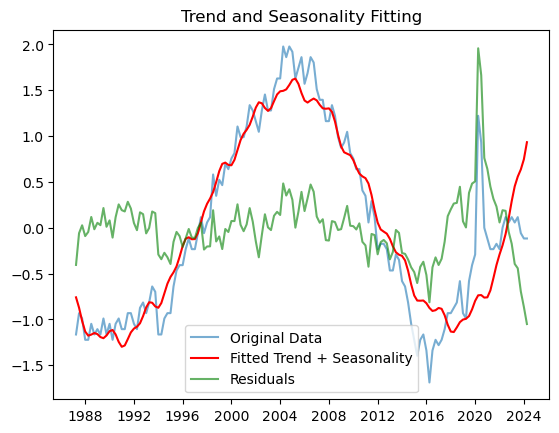

ADF Statistic: -4.275070304905831
p-value: 0.0004905024775002555
Residuals are stationary (reject null hypothesis).


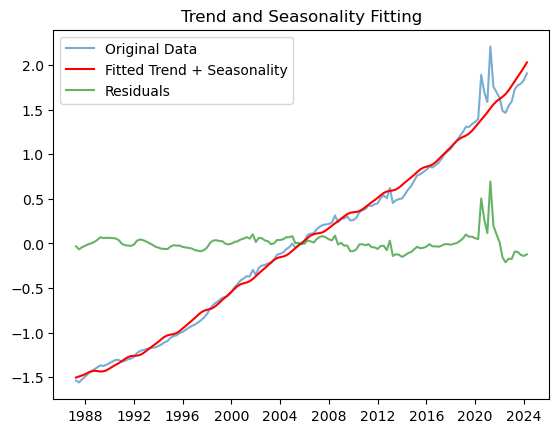

ADF Statistic: -4.215817913893027
p-value: 0.0006194335522808965
Residuals are stationary (reject null hypothesis).


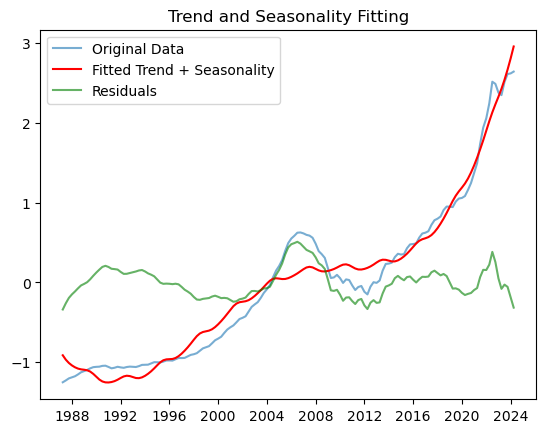

ADF Statistic: -3.444395801528945
p-value: 0.009535375847598114
Residuals are stationary (reject null hypothesis).


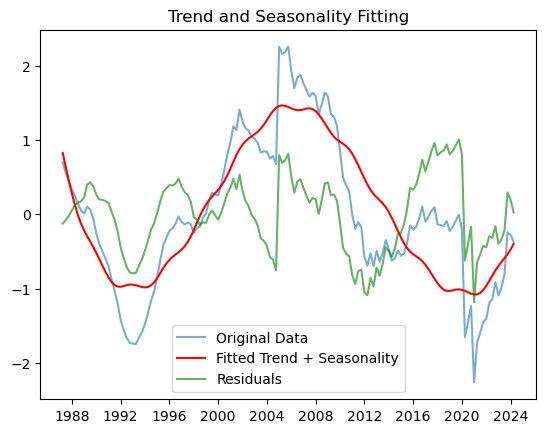

In [67]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from statsmodels.tsa.statespace.tools import diff
from statsmodels.api import OLS
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller


def make_stationary(series):
    data = series['data']
    # Step 1: Create a spline basis for trend
    time = np.arange(len(data))
    spline_basis = dmatrix("bs(time, df=5, degree=3, include_intercept=True)", {"time": time})

    # Step 2: Create Fourier terms for seasonality
    frequency = 12  # Assume monthly seasonality for this example
    k = 2  # Number of Fourier terms
    fourier_terms = np.column_stack([np.sin(2 * np.pi * time * j / frequency) for j in range(1, k + 1)] +
                                    [np.cos(2 * np.pi * time * j / frequency) for j in range(1, k + 1)])

    # Step 3: Combine trend and seasonality into a single model
    X = np.hstack([spline_basis, fourier_terms])  # Combine trend and seasonality
    model = OLS(data, X).fit()

    # Step 4: Calculate fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = data - fitted_values

    # Step 5: Verify stationarity of residuals
    adf_result = adfuller(residuals)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] < 0.05:
        print("Residuals are stationary (reject null hypothesis).")
    else:
        print("Residuals are not stationary (fail to reject null hypothesis).")

    plt.plot(series['time'], data, label="Original Data", alpha=0.6)
    plt.plot(series['time'], fitted_values, label="Fitted Trend + Seasonality", color="red")
    plt.plot(series['time'], residuals, label="Residuals", color="green", alpha=0.6)
    plt.legend()
    plt.title("Trend and Seasonality Fitting")
    plt.show()

    return residuals

# stationary data
merged_data = merged_data.reset_index()
merged_data['HomeOwnerStat'] = make_stationary(merged_data[['DATE', 'HomeOwnershipRate_std']].rename(columns={'HomeOwnershipRate_std': 'data', 'DATE': 'time'}))
merged_data['IncomeStat'] = make_stationary(merged_data[['DATE', 'Income_std']].rename(columns={'Income_std': 'data', 'DATE': 'time'}))
merged_data['HpStat'] = make_stationary(merged_data[['DATE', 'HPIndex_std']].rename(columns={'HPIndex_std': 'data', 'DATE': 'time'}))
merged_data['CDStat'] = make_stationary(merged_data[['DATE', 'ConsumerDebtIndex_std']].rename(columns={'ConsumerDebtIndex_std': 'data', 'DATE': 'time'}))

stationary_data = merged_data[['HomeOwnerStat', 'IncomeStat', 'HpStat', 'CDStat']]

In [68]:
stationary_data

,HomeOwnerStat,IncomeStat,HpStat,CDStat
0,-0.405101,-0.034001,-0.338300,-0.125950
1,-0.059317,-0.067195,-0.260448,-0.079272
2,0.027012,-0.042327,-0.193193,-0.019930
3,-0.090518,-0.027154,-0.148595,0.054729
4,-0.045361,-0.009802,-0.112412,0.126704
...,...,...,...,...
144,-0.394175,-0.090784,-0.079453,-0.342594
145,-0.441744,-0.097015,-0.026609,-0.216033
146,-0.694305,-0.129215,-0.054789,0.293551
147,-0.863981,-0.140724,-0.187542,0.193820
